# Optimisation of (pseudo-) random number generation

This notebook is the demonstration of the code used in production in the `densify_Bragg` application.

This story started with 5 lines of `numpy` to generate images made of pixels having each their own mean and standard deviation. Images are composed of several mega-pixels and there are thousands of them. The 5 lines of Python are providing a proper result but with its 10 frames per seconds, it is far too slow, and the client expects at least 100 to process the image-stack reasonably fast.

Since this is intended to be production code, hence widely distributed, my favorite tool, the GPU gets discarded. So I am stucked with Python and some tools already in use within the project: Cython and a C/C++ compiler. Since the code needs to run on any platform (windows, macos and linux to the least) and on many achitectures x86, amd64, ppc64le and arm64 among other. Other fancy tools like OpenMP are neither an option since it is not supported on macos.

Naively, I started to rewrite this function in C, sure that this would be enough ... how disapointed was I when I realized it was even slower than the initial Python !

This triggered some rationnal benchmarking on random number generation that I would like to share with you.

First of all, all pseudo random numbers, like the one obtained from a normal distribution are derived from an uniform distribution, and one of the most commonly used generator is based on the Mesenne-Twister. While is not cryptographically strong, it is neverthless enough for our needs.

*Disclaimer:* I am not a guru in C nor in C++, so I would be pleased if you can help me fixing some code if you believe it is sub-optimal.

## Some reference `Numpy` code and figures

In [1]:
%matplotlib inline
import sys, time, random
start_time = time.perf_counter()
print(sys.version)

3.12.3 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:50:38) [GCC 11.2.0]


In [2]:
import numpy
from matplotlib.pyplot import subplots

#This is the size of one image:
shape = (2167,2070)

Reference timing from numpy: Uniform
37.8 ms ± 508 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Reference timing from numpy: Normal
127 ms ± 6.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


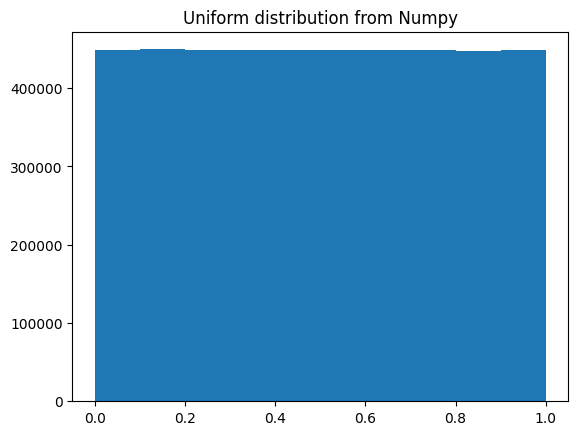

In [3]:
#Those are reference figures obtained from Numpy
print("Reference timing from numpy: Uniform")
%timeit numpy.random.random(shape)
print("Reference timing from numpy: Normal")
%timeit numpy.random.normal(0, 1, size=shape)
fig, ax = subplots()
ax.hist(numpy.random.random(shape).ravel())
ax.set_title("Uniform distribution from Numpy");

With figures like 110ms for 4 Mpix of random values, it makes clear that 10 fps is a hard limit for those frame generation: Almost all the time is spent in generating those random numbers ! 

Let's see how the `rand` function from the standard C library behaves. 

## Cython implementation of the `C-rand`

The C-standard library pseudo-random number generator is not of the greatest quality, but this is probably not of great importance in this case. We have a performance issue ! Let's look at some simple and direct call to `rand` via Cython. Nothing fancy, but the benchmarks !

Thanks Jupyter for letting use code and profile cython code interactively.

In [4]:
%load_ext Cython

In [5]:
%%cython
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False
import time
import numpy
from libc.stdint cimport uint64_t
from libc.stdlib cimport rand, RAND_MAX, srand

srand(<unsigned int> (time.time_ns()%RAND_MAX))

def cython_uniform_rand(shape):
    cdef uint64_t size = numpy.prod(shape), idx
    cdef double[::1] ary = numpy.empty(size)
    with nogil:
        for idx in range(size):
            ary[idx] = rand()/(RAND_MAX+1.0)
    return numpy.asarray(ary).reshape(shape)

Using the C-rand function from Cython
80.9 ms ± 898 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


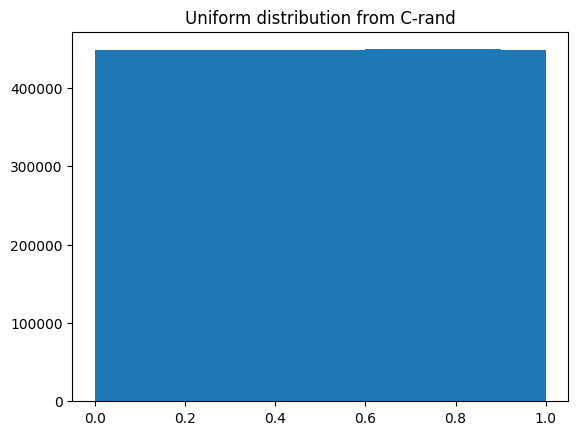

In [6]:
print("Using the C-rand function from Cython")
%timeit cython_uniform_rand(shape)
fig, ax = subplots()
ax.hist(cython_uniform_rand(shape).ravel())
ax.set_title("Uniform distribution from C-rand");

The distribution looks OK but the C-rand function is almost **twice slower** than the equivalent numpy function !
This explains why rewriting the function in cython with C-rand is actually slower than the initial numpy implementation (which was 5 lines long!).


## C++ bound with Cython

A friend of mind advertised C++, a great programming language which standard library implements many random number generator, most of them of much better quality than the one from C. Moreover, the normal distribution is directly available which makes it a great candidate for my problem and created great hopes for faster processing.

I started coding on the examples provided and discovered the PRNG-feature requires a fairly recent compiler, compatible with C++-11. This is the first cold shower, I nevertheless offered C++ a try:

In [7]:
%%cython
# distutils: language = c++
# distutils: extra_compile_args = -std=c++11
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False

import cython
import numpy
import time
cdef extern from "<random>" namespace "std":
    cdef cppclass mt19937:
        mt19937() nogil# we need to define this constructor to stack allocate classes in Cython
        mt19937(unsigned int seed) # not worrying about matching the exact int type for seed
    cdef cppclass mt19937_64:
        mt19937_64() nogil
        mt19937_64(unsigned long long seed)
    cdef cppclass uniform_real_distribution[T]:
        uniform_real_distribution()
        uniform_real_distribution(T a, T b)
        T operator()(mt19937 gen) nogil # ignore the possibility of using other classes for "gen"
        T operator()(mt19937_64 gen) nogil # ignore the possibility of using other classes for "gen"
    cdef cppclass normal_distribution[T]:
        normal_distribution() nogil
        normal_distribution(T a, T b) nogil
        T operator()(mt19937 gen) nogil # ignore the possibility of using other classes for "gen"
        T operator()(mt19937_64 gen) nogil # ignore the possibility of using other classes for "gen"
        
def test():
    cdef:
        mt19937 gen = mt19937(5)
        uniform_real_distribution[double] dist = uniform_real_distribution[double](0.0,1.0)
    return dist(gen)

def cython_uniform_cpp(shape):
    cdef: 
        Py_ssize_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        mt19937 gen = mt19937(time.time_ns()&((1<<32)-1))
        uniform_real_distribution[double] dist = uniform_real_distribution[double](0.0, 1.0)
    with nogil:
        for idx in range(size):
            ary[idx] = dist(gen)
    return numpy.asarray(ary).reshape(shape)

def cython_uniform64_cpp(shape):
    cdef: 
        Py_ssize_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        mt19937_64 gen = mt19937_64(time.time_ns())
        uniform_real_distribution[double] dist = uniform_real_distribution[double](0.0,1.0)
    with nogil:
        for idx in range(size):
            ary[idx] = dist(gen)
    return numpy.asarray(ary).reshape(shape)

def cython_normal_cpp(mu, sigma):
    shape = mu.shape
    assert sigma.shape == shape
    cdef: 
        Py_ssize_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        double[::1] cmu = numpy.ascontiguousarray(mu).ravel()
        double[::1] csigma = numpy.ascontiguousarray(sigma).ravel()
        mt19937 gen = mt19937(time.time_ns()&((1<<32)-1))
        normal_distribution[double] dist
    with nogil:
        for idx in range(size):
            dist = normal_distribution[double](cmu[idx], csigma[idx])
            ary[idx] = dist(gen)
    return numpy.asarray(ary).reshape(shape)

def cython_normal64_cpp(mu, sigma, seed=None):
    shape = mu.shape
    assert sigma.shape == shape
    cdef: 
        Py_ssize_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        double[::1] cmu = numpy.ascontiguousarray(mu).ravel()
        double[::1] csigma = numpy.ascontiguousarray(sigma).ravel()
        mt19937_64 gen = mt19937_64(time.time_ns() if seed is None else seed)
        normal_distribution[double] dist
    with nogil:
        for idx in range(size):
            dist = normal_distribution[double](cmu[idx], csigma[idx])
            ary[idx] = dist(gen)
    return numpy.asarray(ary).reshape(shape)

Execution time from C++:
Uniform distribution, 32 and 64 bits versions of Mersenne twisters:
84.1 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.6 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Normal distribution, 32 and 64 bits versions of Mersenne twisters:
351 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
257 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


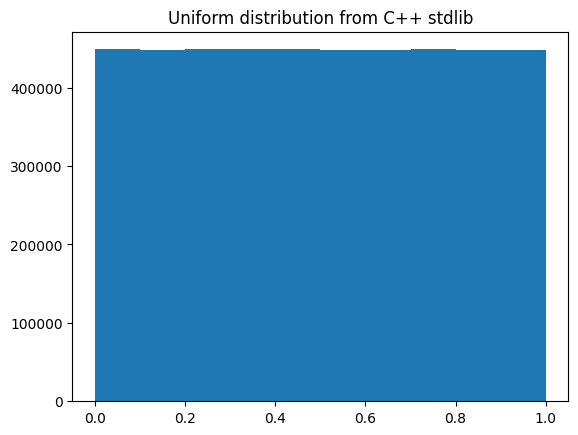

In [8]:
print("Execution time from C++:")
print("Uniform distribution, 32 and 64 bits versions of Mersenne twisters:")
%timeit cython_uniform_cpp(shape)
%timeit cython_uniform64_cpp(shape)
print("Normal distribution, 32 and 64 bits versions of Mersenne twisters:")
a=numpy.ones(shape)
%timeit cython_normal_cpp(a,a)
%timeit cython_normal64_cpp(a,a)
fig, ax = subplots()
ax.hist(cython_uniform64_cpp(shape).ravel())
ax.set_title("Uniform distribution from C++ stdlib");

This is really disappointing! While C++ offers ready to use pseudo random number gernertors, which looks OK, but their performances are at least twice slower than what numpy offers !

Note: the 32-bits version is even slower than the 64 bits version (running on a 64-bits computer)

Sorry C++ is not the proper tool.

## Numpy's C-API

Since *numpy* was found to be the fastest, I descided to use the tools available within it. 

I do not especially like the idea of direct binding to the numpy ABI because it is likely to make the binaries much more difficult to distribute via `pip` and end-users are likely to experience random segmentation faults if they use a numpy version which is different from the one used for packaging.

I found this code pretty complicated with those *PyCapsules*, but it is just a copy/paste from what was found on the numpy documentation at https://numpy.org/doc/stable/reference/random/extending.html

The PCG generator is apparently better in quality than the Mersenne-Twister used with the C++ test.

In [9]:
%%cython
# cython: language_level=3
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False

"""
This file shows how the to use a BitGenerator to create a distribution.
"""
import numpy
from cpython.pycapsule cimport PyCapsule_IsValid, PyCapsule_GetPointer
from libc.stdint cimport uint16_t, uint64_t
from numpy.random cimport bitgen_t
# from numpy.random import PCG64
from numpy.random import MT19937
from numpy.random.c_distributions cimport (
      random_standard_uniform_fill, random_standard_uniform_fill_f)

def cython_uniform_cnp(shape):
    """
    Create an array of `n` uniformly distributed doubles.
    A 'real' distribution would want to process the values into
    some non-uniform distribution
    """
    cdef:
        Py_ssize_t i, n=numpy.prod(shape)
        bitgen_t *rng
        const char *capsule_name = "BitGenerator"
        double[::1] random_values

    # x = PCG64()
    x = MT19937()
    capsule = x.capsule
    # Optional check that the capsule if from a BitGenerator
    if not PyCapsule_IsValid(capsule, capsule_name):
        raise ValueError("Invalid pointer to anon_func_state")
    # Cast the pointer
    rng = <bitgen_t *> PyCapsule_GetPointer(capsule, capsule_name)
    random_values = numpy.empty(n, dtype='float64')
    with x.lock, nogil:
        for i in range(n):
            # Call the function
            random_values[i] = rng.next_double(rng.state)
    randoms = numpy.asarray(random_values)

    return randoms.reshape(shape)

Performance obtained from the C-API of Numpy
35.8 ms ± 557 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


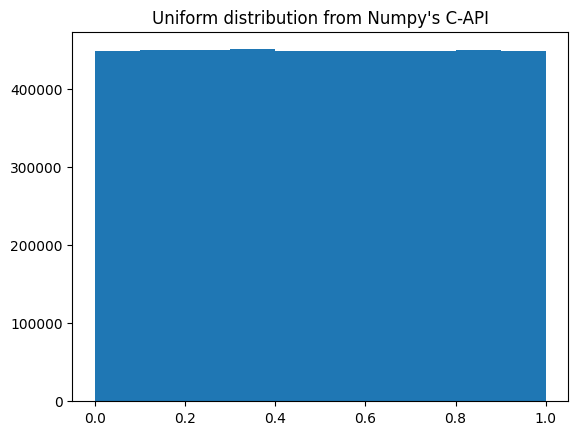

In [10]:
print("Performance obtained from the C-API of Numpy")
%timeit cython_uniform_cnp(shape)
fig, ax = subplots()
ax.hist(cython_uniform_cnp(shape).ravel())
ax.set_title("Uniform distribution from Numpy's C-API");

Finally ! this solution gives faster random number than both the C and C++ version, and even slightly faster than the numpy version. But this is normal: I removed most of the flexibility offered by numpy and tailored it to my needs.

## Cython written Mersenne-twisters

As an alternative, I found the same algorithm we tested in C++, already implemented in Cython:
https://github.com/ananswam/cython_random

This again the Mersenne-twister. Let's see how it behaves:

In [11]:
%%cython
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False
import numpy
cimport numpy as np
import time

# MT Stuff
cdef unsigned NN = 312
cdef unsigned MM = 156
cdef unsigned long long MATRIX_A = 0xB5026F5AA96619E9ULL
cdef unsigned long long UM = 0xFFFFFFFF80000000ULL
cdef unsigned long long LM = 0x7FFFFFFFULL
cdef unsigned long long mt[312]
cdef unsigned mti = NN + 1
cdef unsigned long long mag01[2]

cdef mt_seed(unsigned long long seed):
    global mt
    global mti
    global mag01
    global NN
    global MATRIX_A
    mt[0] = seed
    for mti in range(1,NN):
        mt[mti] = (6364136223846793005ULL * (mt[mti-1] ^ (mt[mti-1] >> 62)) + mti)

    mag01[0] = 0ULL
    mag01[1] = MATRIX_A
    mti = NN


cdef unsigned long long genrand64() nogil:
    cdef int i
    cdef unsigned long long x
    global mag01
    global mti
    global mt
    global NN
    global MM
    global UM
    global LM

    if mti >= NN:
        for i in range(NN-MM):
            x = (mt[i]&UM) | (mt[i+1]&LM)
            mt[i] = mt[i+MM] ^ (x>>1) ^ mag01[int(x&1ULL)]

        for i in range(NN-MM, NN-1):
            x = (mt[i]&UM)|(mt[i+1]&LM)
            mt[i] = mt[i+(MM-NN)] ^ (x>>1) ^ mag01[int(x&1ULL)]

        x = (mt[NN-1]&UM)|(mt[0]&LM)
        mt[NN-1] = mt[MM-1] ^ (x>>1) ^ mag01[int(x&1ULL)]
        mti = 0

    x = mt[mti]
    mti += 1
    x ^= (x >> 29) & 0x5555555555555555ULL
    x ^= (x << 17) & 0x71D67FFFEDA60000ULL
    x ^= (x << 37) & 0xFFF7EEE000000000ULL
    x ^= (x >> 43);

    return x

def py_rand_int():
    return genrand64()

# Functions

# Seed the random number generator
cdef seed_random(seed=None):
    """
    Seed the C random number generator with the current system time.
    :return: none
    """
    if seed is None:
        mt_seed(time.time_ns())
    else:
        mt_seed(seed)

def py_seed_random(unsigned long long seed = 0):
    seed_random(seed)

cdef double uniform_rv() nogil:
    """
    Generate a uniform random variable in [0,1]
    :return: (double) a random uniform number in [0,1]
    """
    return (genrand64() >> 11) * (1.0/9007199254740991.0)

def cython_uniform_mt(shape):
    cdef Py_ssize_t size = numpy.prod(shape), idx
    cdef double[::1] ary = numpy.empty(size)
    mt_seed(time.time_ns())
    with nogil:
        for idx in range(size):
            ary[idx] = uniform_rv()
    return numpy.asarray(ary).reshape(shape)

Performances of MT64 implemented in Cython
39.8 ms ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


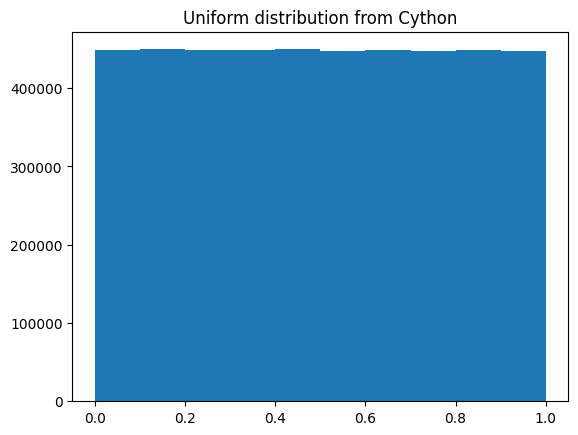

In [12]:
print("Performances of MT64 implemented in Cython")
%timeit cython_uniform_mt(shape)
fig, ax = subplots()
ax.hist(cython_uniform_mt(shape).ravel())
ax.set_title("Uniform distribution from Cython");

Eureka ! This cython implementation is as fast as the numpy one, and much faster than the C or C++ implementations.

Well I don't like the global variable and minor things in this code, but with just 50 lines of code, my problem is finding a solution ! Thanks Anandh Swaminathan for sharing this code.

Here is the re-written version with a class to allow to have multiple generators with different seeds (Well, not that robust, but better than sharing the same seed and creating a bottleneck for the random number generation).

In [13]:
%%cython
# cython: boundscheck=False
# cython: cdivision=True
# cython: wraparound=False

import cython
import time
import numpy
from libc.stdlib cimport RAND_MAX
from libc.stdint cimport uint32_t, uint64_t
from libc.math cimport log, sqrt, cos, M_PI

#Few constants for 64-bit Mersenne Twisters
cdef:
    uint32_t NN=312
    uint32_t MM=156
    uint64_t MATRIX_A=0xB5026F5AA96619E9ULL
    uint64_t UM=0xFFFFFFFF80000000ULL # Most significant 33 bits
    uint64_t LM=0x7FFFFFFFULL #Least significant 31 bits
    double EPS64 = numpy.finfo(numpy.float64).eps
    double TWO_PI = 2.0 * M_PI   
    double NRM53 = 1.0/((1<<53)-1) # normalization factor for uniform

cdef class MT:
    """
    This class implements 64-bit Mersenne Twisters
    
    http://www.math.sci.hiroshima-u.ac.jp/m-mat/MT/VERSIONS/C-LANG/mt19937-64.c
    
    Inspired from:
    https://github.com/ananswam/cython_random
    with minor clean-ups
    
    Licence: MIT
    """
    cdef:
        uint64_t mt[312]
        uint32_t mti
        uint64_t mag01[2]
        bint has_spare
        double spare
    
    def __init__(self, seed):
        self.mti = NN + 1
        self._seed(<uint64_t> seed)
    
    cdef inline void _seed(self, uint64_t seed) noexcept nogil:
        self.mt[0] = seed
        for self.mti in range(1, NN):
            self.mt[self.mti] = (6364136223846793005ULL * (self.mt[self.mti-1] ^ (self.mt[self.mti-1] >> 62)) + self.mti)
        self.mag01[0] = 0ULL
        self.mag01[1] = MATRIX_A
        self.mti = NN
        self.has_spare = False
        
    cdef inline uint64_t genrand64(self) noexcept nogil:
        cdef: 
            uint32_t i
            uint64_t x
        if self.mti >= NN:
            for i in range(NN - MM):
                x = (self.mt[i]&UM) | (self.mt[i+1]&LM)
                self.mt[i] = self.mt[i+MM] ^ (x>>1) ^ self.mag01[int(x&1ULL)]

            for i in range(NN-MM, NN-1):
                x = (self.mt[i]&UM)|(self.mt[i+1]&LM)
                self.mt[i] = self.mt[i+(MM-NN)] ^ (x>>1) ^ self.mag01[int(x&1ULL)]

            x = (self.mt[NN-1]&UM)|(self.mt[0]&LM)
            self.mt[NN-1] = self.mt[MM-1] ^ (x>>1) ^ self.mag01[int(x&1ULL)]
            self.mti = 0

        x = self.mt[self.mti]
        self.mti += 1
        x ^= (x >> 29) & 0x5555555555555555ULL
        x ^= (x << 17) & 0x71D67FFFEDA60000ULL
        x ^= (x << 37) & 0xFFF7EEE000000000ULL
        x ^= (x >> 43);
        return x
    
    def rand(self):
        return self.genrand64()%(RAND_MAX+1ULL)
    
    cdef inline double _uniform(self) noexcept nogil:
        return (self.genrand64() >> 11) * NRM53
    
    def uniform(self):
        "Return a random value between [0:1["
        return self._uniform()
    
    cdef inline double _normal_bm(self, double mu, double sigma) noexcept nogil:
        cdef:
            double u1=0.0, u2=0.0
    
        while (u1 == 0.0 ):
            u1 = self._uniform()
            u2 = self._uniform()

        return sigma * sqrt(-2.0 * log(u1)) * cos(TWO_PI * u2) + mu;

    def normal_bm(self, mu, sigma): 
        """
        Calculate the gaussian distribution using the Box–Muller algorithm

        Credits:
        https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform

        :param mu: the center of the distribution
        :param sigma: the width of the distribution
        :return: random value
        """       
        return self._normal(mu, sigma)
    
    cdef inline double _normal_m(self, double mu, double sigma) noexcept nogil:
        cdef: 
            double u1=0.0, u2=0.0, s=0.0
        if self.has_spare:
            self.has_spare = False
            return mu + self.spare * sigma 
        else:
            while (s>=1.0 or s<=0.0):
                u1 = 2.0 * self._uniform() - 1.0
                u2 = 2.0 * self._uniform() - 1.0
                s = u1 * u1 + u2 * u2;
            s = sqrt(-2.0*log(s)/s)
            self.spare = u2 * s
            self.has_spare = True
        return mu + sigma * u1 * s;
        
    def normal_m(self, mu, sigma):
        """Implement Marsaglia polar method
        https://en.wikipedia.org/wiki/Marsaglia_polar_method
        """
        return self._normal_m(mu, sigma)


def cython_uniform_mtc(shape, seed=None):
    cdef: 
        uint64_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        MT mt = MT(time.time_ns() if seed is None else seed)
    with nogil:
        for idx in range(size):
            ary[idx] = mt._uniform()
    return numpy.asarray(ary).reshape(shape)      

def cython_normal_bm_mtc(mu, sigma, seed=None):
    shape = mu.shape
    assert mu.shape == sigma.shape
    cdef: 
        uint64_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        double[::1] cmu = numpy.ascontiguousarray(mu, dtype=numpy.float64).ravel()
        double[::1] csigma = numpy.ascontiguousarray(sigma, dtype=numpy.float64).ravel()
        MT mt = MT(time.time_ns() if seed is None else seed)
        
    with nogil:
        for idx in range(size):
            ary[idx] = mt._normal_bm(cmu[idx], csigma[idx])
    return numpy.asarray(ary).reshape(shape)      

def cython_normal_m_mtc(mu, sigma, seed=None):
    shape = mu.shape
    assert mu.shape == sigma.shape
    cdef: 
        uint64_t size = numpy.prod(shape), idx
        double[::1] ary = numpy.empty(size)
        double[::1] cmu = numpy.ascontiguousarray(mu, dtype=numpy.float64).ravel()
        double[::1] csigma = numpy.ascontiguousarray(sigma, dtype=numpy.float64).ravel()
        MT mt = MT(time.time_ns() if seed is None else seed)
        
    with nogil:
        for idx in range(size):
            ary[idx] = mt._normal_m(cmu[idx], csigma[idx])
    return numpy.asarray(ary).reshape(shape)      

Performances of the cdef class for Mersenne-twisters implemented in Cython
30.9 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


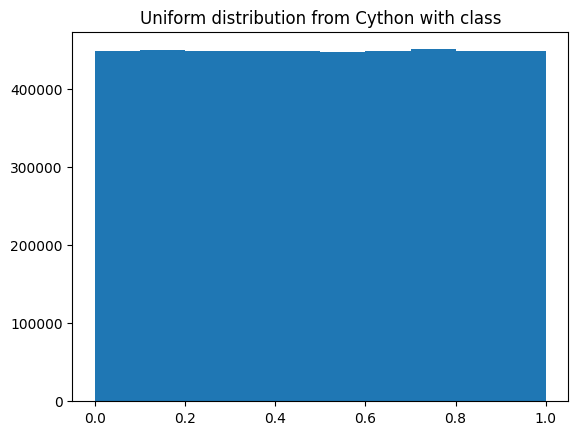

In [14]:
print("Performances of the cdef class for Mersenne-twisters implemented in Cython")
%timeit cython_uniform_mtc(shape)
fig, ax = subplots()
ax.hist(cython_uniform_mtc(shape).ravel())
ax.set_title("Uniform distribution from Cython with class");

This version with a class is even slightly faster. Let's double check the results are corrects. But before, let's summarise the performances obtained:

## Summary of the performances obtained 

### Against Python

In [15]:
print("Performances of the raw random number generator")
print("="*47)
mt = MT(0)
x = MT19937()
NRM = 1.0/(1<<31)
timeit_random_random = %timeit -o -q random.random()
print(f'{"Random module from Python":25s}: {timeit_random_random.best*1e9:.3f} ns')
timeit_cython_uniform = %timeit -o -q  mt.uniform()
print(f'{"MT written in Cython":25s}: {timeit_cython_uniform.best*1e9:.3f} ns')
timeit_mt_numpy = %timeit -o -q  x.random_raw()*NRM
print(f'{"MT written in Numpy":25s}: {timeit_mt_numpy.best*1e9:.3f} ns')

Performances of the raw random number generator
Random module from Python: 42.016 ns
MT written in Cython     : 35.721 ns
MT written in Numpy      : 309.401 ns


In [16]:
# Comparison of the performances of the various implementations
print("Comparison of the performances of the various implementations:")
timeit_numpy = %timeit -o -q numpy.random.random(shape)
print(f'{"Numpy from Python":60s}: {timeit_numpy.best*1000:.3f} ms')
timeit_rand = %timeit -o -q cython_uniform_rand(shape)
print(f'{"Cython with `rand` from C":60s}: {timeit_rand.best*1000:.3f} ms')
timeit_cpp32 = %timeit -o -q cython_uniform_cpp(shape)
print(f'{"Cython with C++ random number generator (32bits)":60s}: {timeit_cpp32.best*1000:.3f} ms')
timeit_cpp64 = %timeit -o -q cython_uniform64_cpp(shape)
print(f'{"Cython with C++ random number generator (64bits)":60s}: {timeit_cpp64.best*1000:.3f} ms')
timeit_cnp = %timeit -o -q cython_uniform_cnp(shape)
print(f'{"Cython with MT from Numpy'via C-API":60s}: {timeit_cnp.best*1000:.3f} ms')
timeit_mt0 = %timeit  -o -q cython_uniform_mt(shape)
print(f'{"Cython with MT implemented in Cython (original)":60s}: {timeit_mt0.best*1000:.3f} ms')
timeit_mt1 = %timeit -o -q cython_uniform_mtc(shape)
print(f'{"Cython with MT implemented in Cython (modified)":60s}: {timeit_mt1.best*1000:.3f} ms')

Comparison of the performances of the various implementations:
Numpy from Python                                           : 37.270 ms
Cython with `rand` from C                                   : 79.540 ms
Cython with C++ random number generator (32bits)            : 79.422 ms
Cython with C++ random number generator (64bits)            : 68.105 ms
Cython with MT from Numpy'via C-API                         : 35.908 ms
Cython with MT implemented in Cython (original)             : 35.238 ms
Cython with MT implemented in Cython (modified)             : 28.887 ms


In [17]:
print("Comparison performances for normal distributions:")
z = numpy.zeros(shape)
s = numpy.ones(shape)
timeit_np_normal = %timeit -o -q numpy.random.normal(z, s)
print(f'{"Distribution from Numpy":40s}: {1000*timeit_np_normal.best:.3f} ms')
timeit_cpp_normal = %timeit -o -q cython_normal64_cpp(z, s)
print(f'{"Distribution from C++ (64 bits)":40s}: {1000*timeit_cpp_normal.best:.3f} ms')
timeit_bm_normal = %timeit -o -q cython_normal_bm_mtc(z, s)
print(f'{"Box-Muller tranformation":40s}: {1000*timeit_bm_normal.best:.3f} ms')
timeit_mt_normal = %timeit -o -q cython_normal_m_mtc(z, s)
print(f'{"Marsaglia transformation":40s}: {1000*timeit_mt_normal.best:.3f} ms')

Comparison performances for normal distributions:
Distribution from Numpy                 : 199.407 ms
Distribution from C++ (64 bits)         : 251.394 ms
Box-Muller tranformation                : 180.956 ms
Marsaglia transformation                : 93.640 ms


In [18]:
npt = 1000
seed = 123 #time.time_ns()
rng = numpy.random.Generator(numpy.random.MT19937(seed=seed))
distrib_random_normal = rng.normal(z, s)
distrib_normal64_cpp = cython_normal64_cpp(z, s, seed=seed)
distrib_normal_bm_mtc = cython_normal_bm_mtc(z, s, seed=seed)
distrib_normal_m_mtc = cython_normal_m_mtc(z, s, seed=seed)
assert distrib_random_normal.shape == shape
assert distrib_normal64_cpp.shape == shape
assert distrib_normal_bm_mtc.shape == shape
assert distrib_normal_m_mtc.shape == shape
ref = numpy.histogram(distrib_random_normal.ravel(), npt)
cpp = numpy.histogram(distrib_normal64_cpp.ravel(), npt)
obt = numpy.histogram(distrib_normal_bm_mtc.ravel(), npt)
obt2 = numpy.histogram(distrib_normal_m_mtc.ravel(), npt)
print(ref[0].sum(), cpp[0].sum(), obt[0].sum(), obt2[0].sum())

4485690 4485690 4485690 4485690


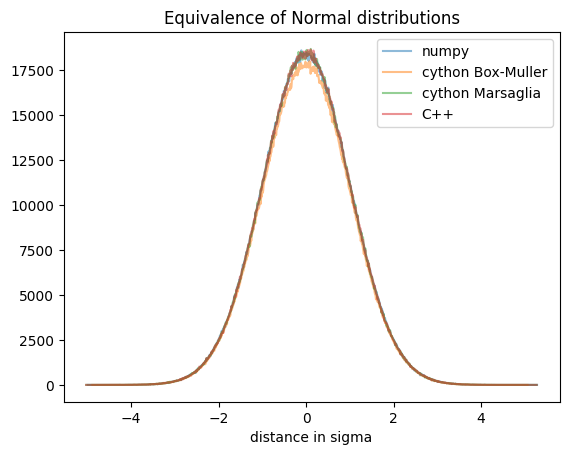

In [22]:
fig, ax = subplots()
ax.plot((ref[1][1:]+ref[1][:-1])/2, ref[0], "-", alpha=0.5, label="numpy")
ax.plot((obt[1][1:]+obt[1][:-1])/2, obt[0], "-", alpha=0.5, label="cython Box-Muller")
ax.plot((obt2[1][1:]+obt2[1][:-1])/2, obt2[0], "-", alpha=0.5, label="cython Marsaglia")
ax.plot((cpp[1][1:]+cpp[1][:-1])/2, cpp[0], "-", alpha=0.5, label="C++")
ax.set_xlabel("distance in sigma")
ax.set_title("Equivalence of Normal distributions")
ax.legend();

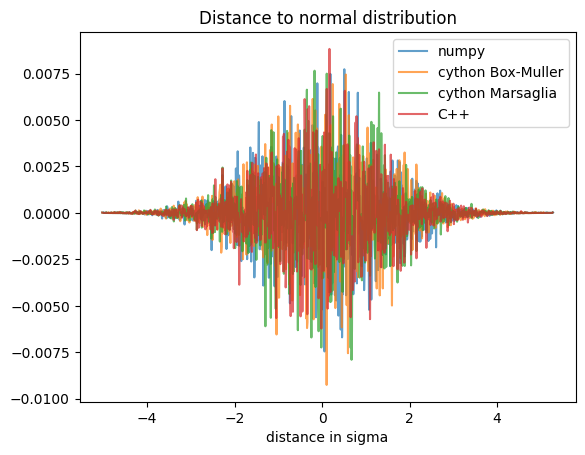

In [20]:
# Distance to normal distribution:
def normal(x, mu, sigma):
    delta = x-mu
    sigma2 = sigma*sigma
    return numpy.exp(-delta*delta/(2*sigma2))/numpy.sqrt(2*numpy.pi*sigma2)

alpha = 0.7

fig, ax = subplots()
x_ref = (ref[1][1:]+ref[1][:-1])/2.0
y_ref = ref[0]/ref[0].sum()*npt/(ref[1][-1]-ref[1][0])
ax.plot(x_ref, y_ref-normal(x_ref,0, 1), 
        "-", alpha=alpha, label="numpy")

x_obt = (obt[1][1:]+obt[1][:-1])/2.0
y_obt = obt[0]/obt[0].sum()*npt/(obt[1][-1]-obt[1][0])
ax.plot(x_obt, y_obt-normal(x_obt, 0, 1), 
        "-", alpha=alpha, label="cython Box-Muller")

x_obt2 = (obt2[1][1:]+obt2[1][:-1])/2.0 
y_obt2 = obt2[0]/obt2[0].sum()*npt/(obt2[1][-1]-obt2[1][0])
ax.plot(x_obt2, y_obt2-normal(x_obt2, 0, 1), 
        "-", alpha=alpha, label="cython Marsaglia")

x_cpp = (cpp[1][1:]+cpp[1][:-1])/2.0
y_cpp = cpp[0]/cpp[0].sum()*npt/(cpp[1][-1]-cpp[1][0])
ax.plot(x_cpp, y_cpp-normal(x_cpp, 0, 1), 
        "-", alpha=alpha, label="C++")
ax.set_title("Distance to normal distribution")
ax.set_xlabel("distance in sigma")
ax.legend();

In [21]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}")

Total execution time: 116.779


There was still a lot of time wasted in converting the uniform distribution to the normal one. This was related to the numerous transcendental functions like `sin`, `cos`, `sqrt` and `log` called in the conversion. The Marsaglia algorithm allows to generate 2 values for 2 polls, and does not use `sin` nor `cos` functions, which actually makes it twice faster than the Box-Muller algorithm. And since we generate billions of random values, this matters!

## Outlook
I created a pool of thread in Python (from multiprocessing) and called the processing of each image in a separated thread. Since the complete generation of the image is in a `nogil` section, this runs efficiently on all cores of the computer. I got a 10x speed-up with multithreading versus the single threaded version on a 8-core computer thanks to hyperthreading. The perfromances are not that fancy but the bottleneck is now somewhere else.


## Conclusions

There are several conclusion one can draw from this:
* Python is not slow !
* Numpy is even fast !
* Re-writting performance critical in C is not a silver bullet
* Re-writting performance critical in C++ does not help either in some cases
* Algorithms matters more than the programming language used !
* Benchmark, profile, measure ... is more deterministic than listening to friends